# Permutation Importance

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import utils
import pandas as pd
from matplotlib.colors import ListedColormap
import colorsys

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects

#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False?

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod
from gewitter_functions import get_acc
from sklearn import metrics
import scipy
from scipy import stats

2025-02-06 15:13:22.210059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Type:        bool
String form: False
Namespace:   Python builtin
Docstring:  
bool(x) -> bool

Returns True when the argument x is true, False otherwise.
The builtins True and False are the only two instances of the class bool.
The class bool is a subclass of the class int, and cannot be subclassed.

### Use Permutation_Importance.py to calculate permutation importance

In [7]:
region_labels = ['90','12','34', '56','78']
region_names = ['1','2','3','4','5']
regions = range(len(region_labels))

r = 0
fp = '/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/'   
permutation_data = [pd.read_csv(fp+'Permutation_Importance/PermutationImportance_region'+str(r), index_col = 0) for r in regions]
region_data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/final_test_ds.nc')
region_data = region_data.where(region_data.n_channel.isin(['V','IWV']), drop = True)
titles = np.array(region_data.n_channel.values)
colors = ['#F6A5AE', '#228833', '#4577AA','#67CCED', '#AA3377']
preds =[pd.read_csv(fp+'Final_preds.csv')[str(r)] for r in regions]


In [8]:
results = pd.read_csv(fp+'Final_preds.csv', index_col = 0)
test = pd.read_csv(fp+'Final_test.csv', index_col = 0)

cutoff = .45
auc_pr = []
for r in range(5):
    predict = np.array(np.where(results[str(r)]>=cutoff,1,0))
    precision, recall, thresholds = metrics.precision_recall_curve(test[str(r)], results[str(r)], pos_label = 1)
    auc_pr.append(np.round(metrics.auc(recall, precision),2))
accuracy = []
for r in range(5):
    predict = np.array(np.where(results[str(r)]>=cutoff,1,0))
    accuracy.append(len(np.where(test[str(r)] == predict)[0])/len(test[str(r)]))

In [9]:
def plot_one_region(r):
    print(auc_pr[r])
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (3,4))

    axes.set_xticklabels([''])
    axes.set_xlim([-.5,1.5])
    axes.tick_params('x', length = 0)
    axes.set_ylim(0,1)
    for v in range(len(titles)):
#         axes.bar(v, 100-(100*(permutation_data[r]['auc_pr_'+titles[v]].values.mean()/auc_pr)), width = .5,color = colors[r])
        axes.bar(v, auc_pr[r] - permutation_data[r]['auc_pr_'+titles[v]].values.mean(), bottom = permutation_data[r]['auc_pr_'+titles[v]].values.mean(), width = .3,color = colors[r])
        upper = np.quantile(permutation_data[r]['auc_pr_'+titles[v]], .95)
        lower = np.quantile(permutation_data[r]['auc_pr_'+titles[v]], .05)
        error = np.reshape((permutation_data[r]['auc_pr_'+titles[v]].values.mean() - lower, upper - permutation_data[r]['auc_pr_'+titles[v]].values.mean()), (2,1))
        axes.errorbar(v,permutation_data[r]['auc_pr_'+titles[v]].values.mean(), yerr = error, linestyle='none', color='black', capsize=5)

    axes.axhline(y=auc_pr[r], color='black', linestyle='--')

    axes.set_xticklabels(['',titles[0], '', titles[1], '']);
    axes.set_ylabel('AUC_PR', size = 10)
#     plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/Permutation_region'+str(r)+'.png', dpi = 300, transparent = True, bbox_inches = 'tight')
    print(scipy.stats.ttest_rel(permutation_data[r]['auc_pr_'+titles[0]].values, permutation_data[r]['auc_pr_'+titles[1]].values, axis = 0 ))

0.82
TtestResult(statistic=-36.24368298383532, pvalue=5.975889788961731e-59, df=99)


/tmp/ipykernel_344147/774248616.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([''])
/tmp/ipykernel_344147/774248616.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['',titles[0], '', titles[1], '']);


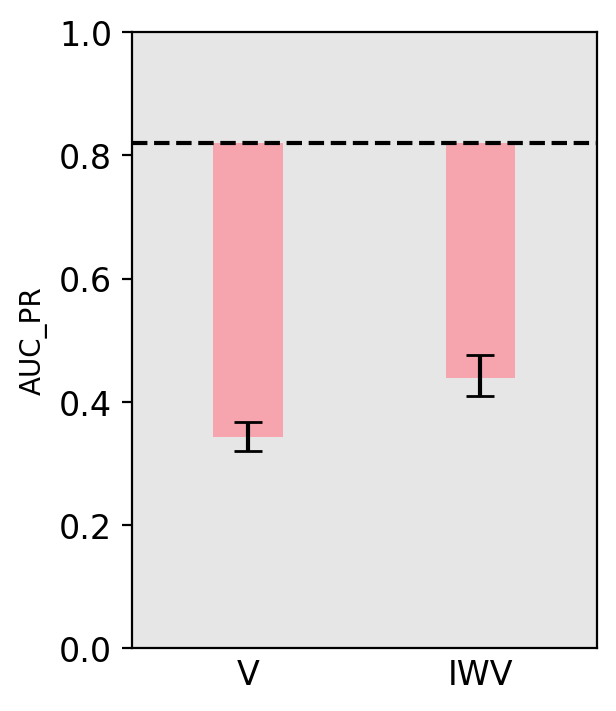

In [10]:
plot_one_region(0)

0.88
TtestResult(statistic=-62.860709058292585, pvalue=1.320450114612912e-81, df=99)


/tmp/ipykernel_344147/774248616.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([''])
/tmp/ipykernel_344147/774248616.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['',titles[0], '', titles[1], '']);


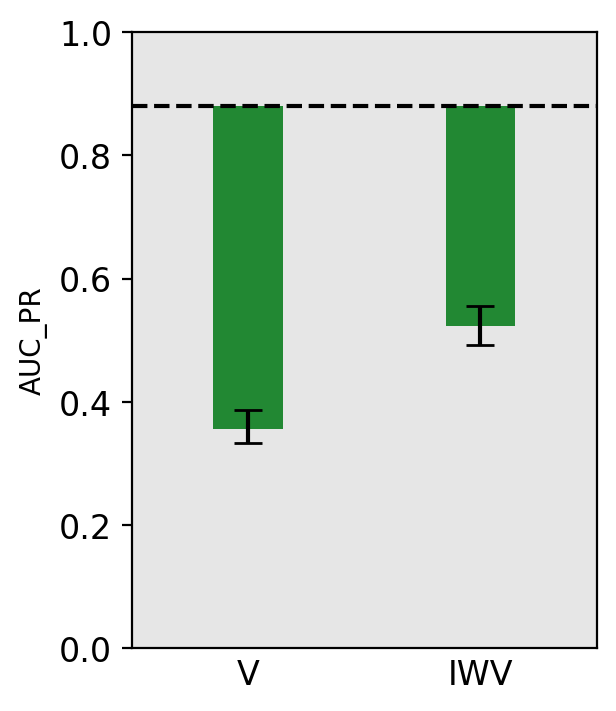

In [11]:
plot_one_region(1)

0.9
TtestResult(statistic=-15.906684818778176, pvalue=5.0322630839721576e-29, df=99)


/tmp/ipykernel_3839723/1272956020.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([''])
/tmp/ipykernel_3839723/1272956020.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['',titles[0], '', titles[1], '']);


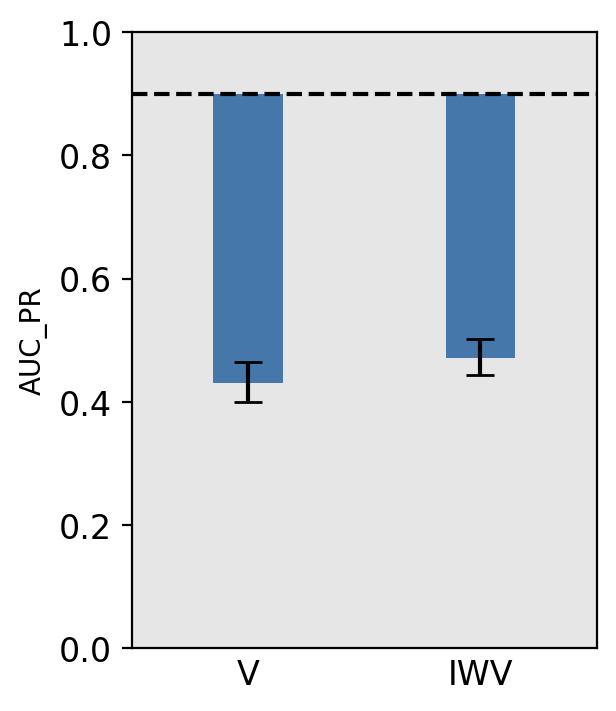

In [141]:
plot_one_region(2)

0.89


/tmp/ipykernel_3839723/1272956020.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([''])
/tmp/ipykernel_3839723/1272956020.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['',titles[0], '', titles[1], '']);


TtestResult(statistic=33.5591132643154, pvalue=6.892761039124282e-56, df=99)


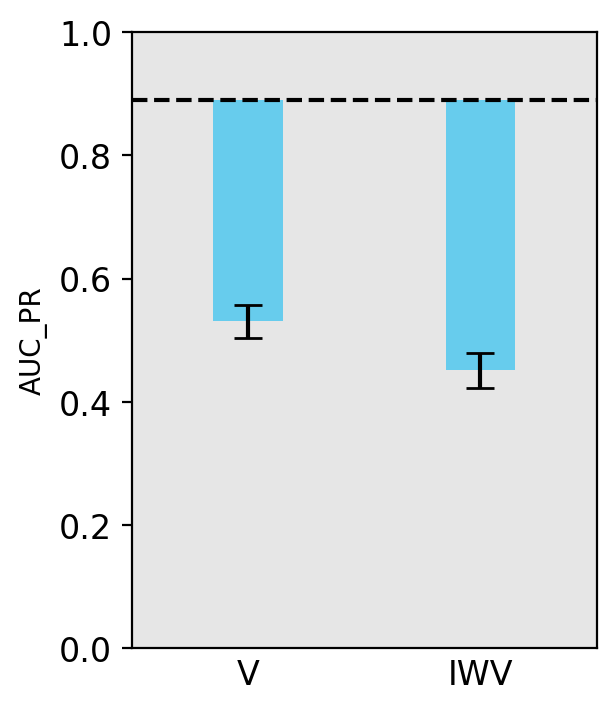

In [142]:
plot_one_region(3)

0.89
TtestResult(statistic=96.59809839209495, pvalue=8.92166931570804e-100, df=99)


/tmp/ipykernel_3839723/1272956020.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([''])
/tmp/ipykernel_3839723/1272956020.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['',titles[0], '', titles[1], '']);


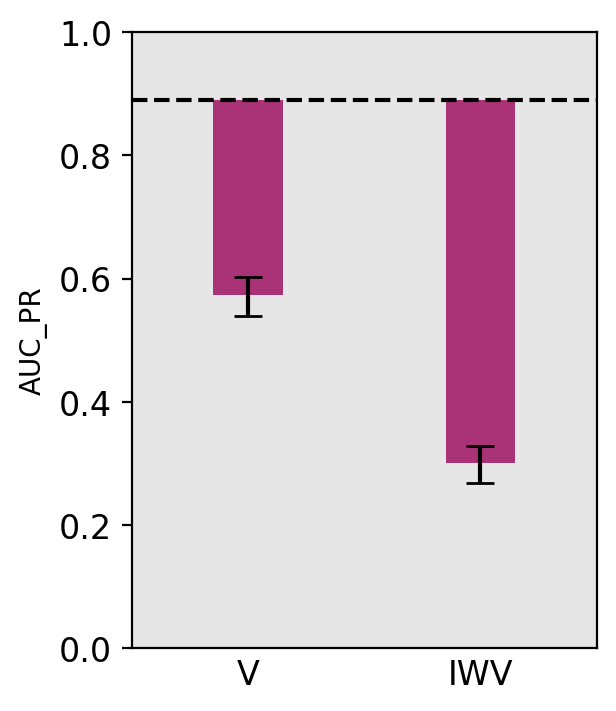

In [143]:
plot_one_region(4)

In [12]:
def plot_one_variable(v):
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (3,4))

    axes.set_xticklabels([''])
    axes.set_title('Variable '+str(titles[v]))
    axes.set_xticks([0,1,2,3,4])
    axes.tick_params('x', length = 0)
    axes.set_ylim(0,100)
    for r in range(5):
#         axes.bar(r, 100 - (100*(permutation_data[r]['auc_pr_'+titles[v]].values.mean()/auc_pr)), width = .5,color = colors[r])
        axes.bar(r, 100 - (100*(permutation_data[r]['auc_pr_'+titles[v]].values.mean())), width = .5,color = colors[r])
    axes.set_xlabel('Regions', size = 12)

    axes.set_xticklabels([1,2,3,4,5]);
    axes.set_ylabel('Decrease in Precision Accuracy (%)', size = 10)


/tmp/ipykernel_344147/1244503539.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([''])


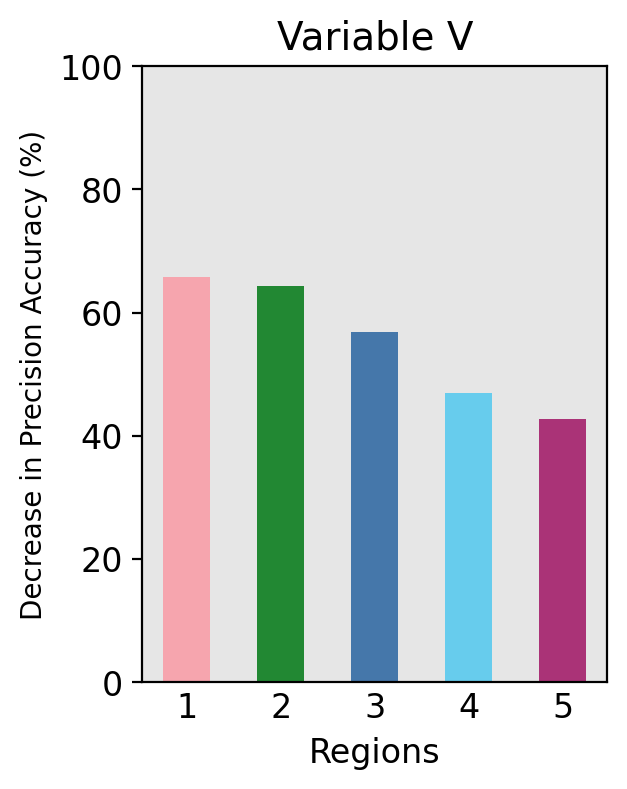

In [13]:
plot_one_variable(0)

/tmp/ipykernel_3839723/1244503539.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([''])


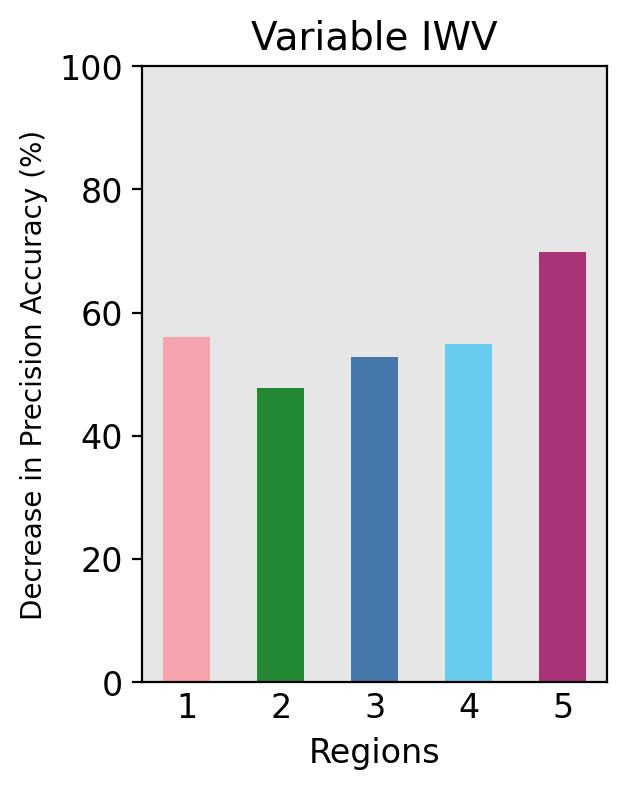

In [137]:
plot_one_variable(1)

/tmp/ipykernel_1387054/1244503539.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([''])


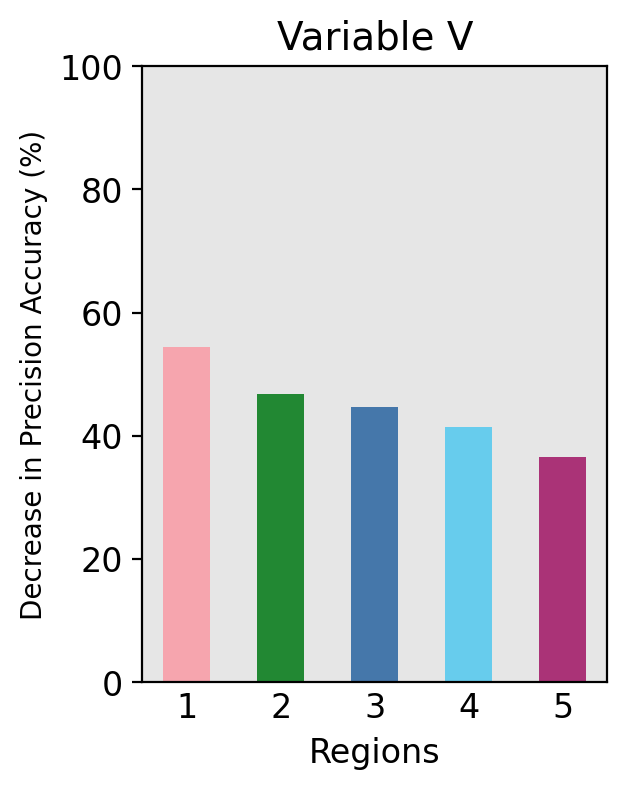

In [75]:
plot_one_variable(2)

/tmp/ipykernel_1387054/1244503539.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([''])


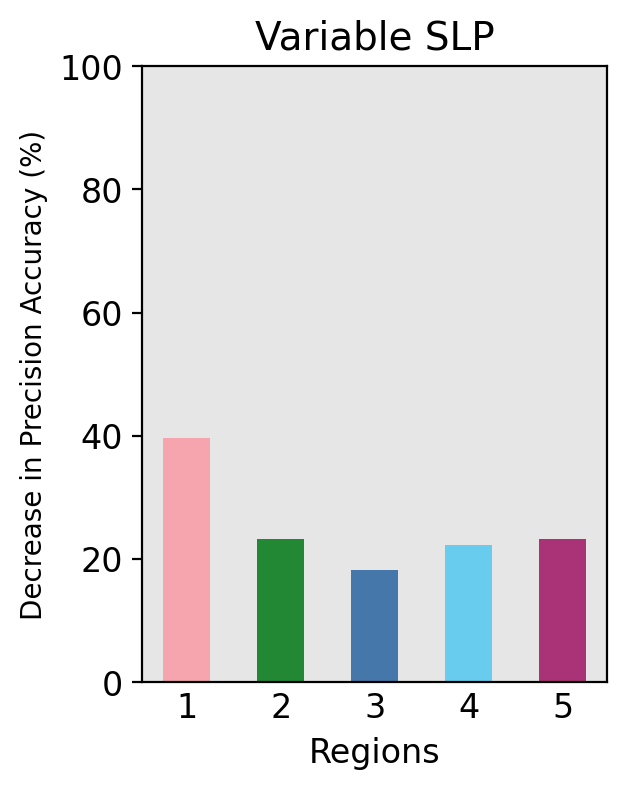

In [76]:
plot_one_variable(3)

/tmp/ipykernel_1387054/1244503539.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([''])


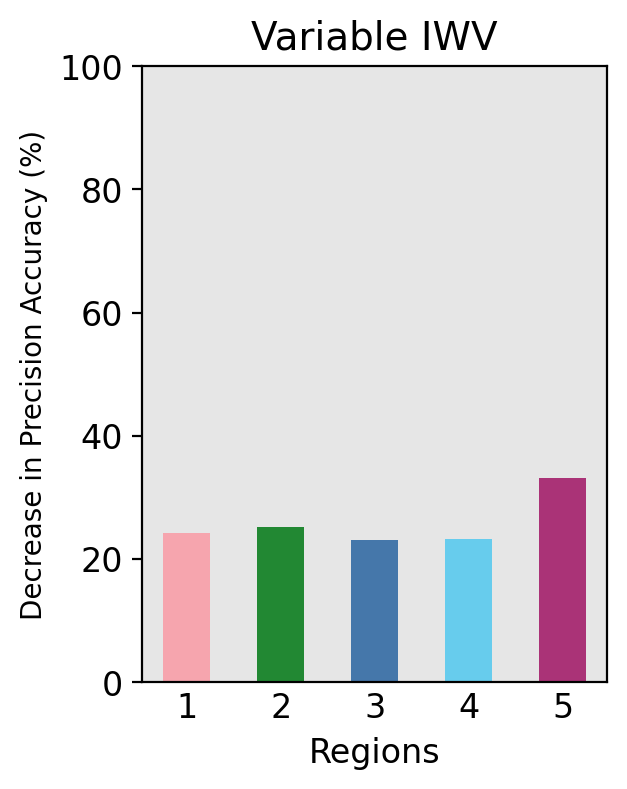

In [77]:
plot_one_variable(4)